### One component mixture, 2D, independent variables

In [1]:
import sys
if "spnhelp" in sys.modules.keys():
    del sys.modules["spnhelp"]
import spnhelp
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
from spn.structure.Base import get_number_of_nodes, Product
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from spn.algorithms.Inference import likelihood
import lgpgm
import math
# plt.rcParams["figure.figsize"] = (3, 3)
# plt.rcParams["figure.dpi"] = 300

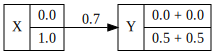

[[1.         0.70710678]
 [0.70710678 1.        ]]
(1000, 1000)
20


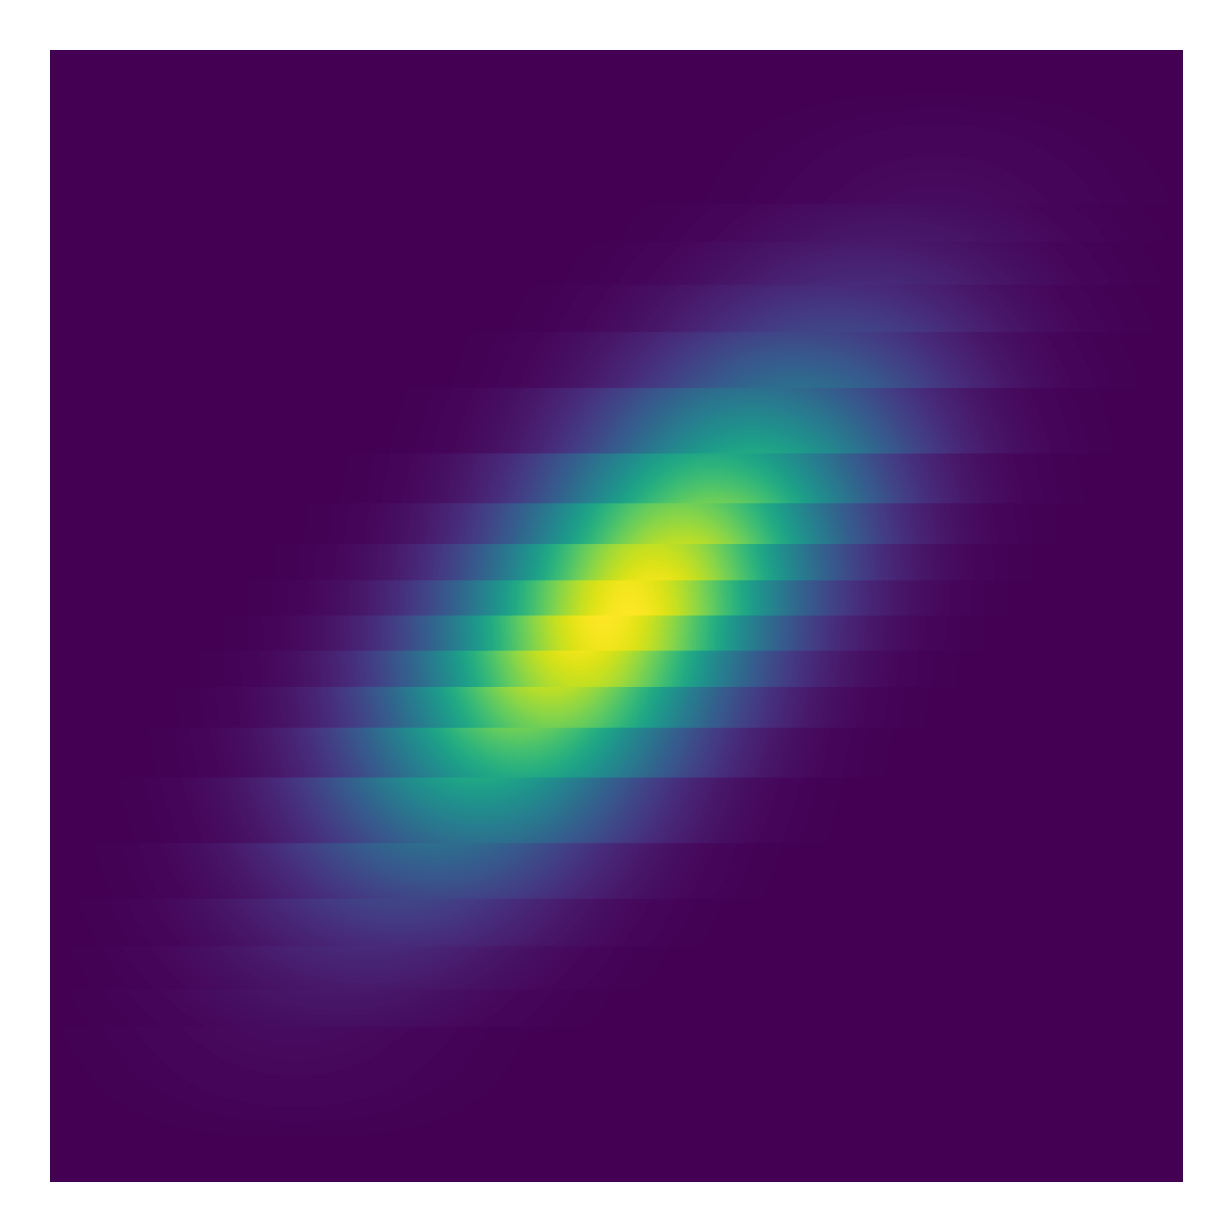

In [14]:
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["figure.dpi"] = 500

X = "X" @ lgpgm.noise
a=0.5
Y = "Y" @ (math.sqrt(a)*X + math.sqrt(1-a)*lgpgm.noise)
display(X.get_BN_graph(True))
print(X.get_Σ().to_numpy())
spn = spnhelp.lgpgm_to_spn(X, crit_param=0.005, crit=spnhelp.CRIT_slopyform_absolute_error, sloped=True)
# display(spnhelp.get_spn_graph(spn, X))




info1 = spnhelp.get_pdf_grid_values(spn, (7, 7), offset = np.array([0, 0]), resolution=1000, )
info2 = spnhelp.get_pdf_grid_values(spn, (7, 7), offset = np.array([0, 0]), resolution=1000, pdf = lambda x : stats.multivariate_normal.pdf(x=x, mean = [0,0], cov=X.get_Σ().to_numpy()))
total = np.column_stack([info2[0], info1[0]])
total = info1[0]
print(total.shape)
spnhelp.show_data((total, (7, 7),  np.array([0, 0])))
plt.gca().axis("off")
# spnhelp.plot_marginals(spn, X, xs = np.linspace(-4, 4, 1000))
print(get_number_of_nodes(spn, Product))

### 2 component mixture with sampling

array([[3.14871162, 0.22735444],
       [0.22735444, 0.75759204]])

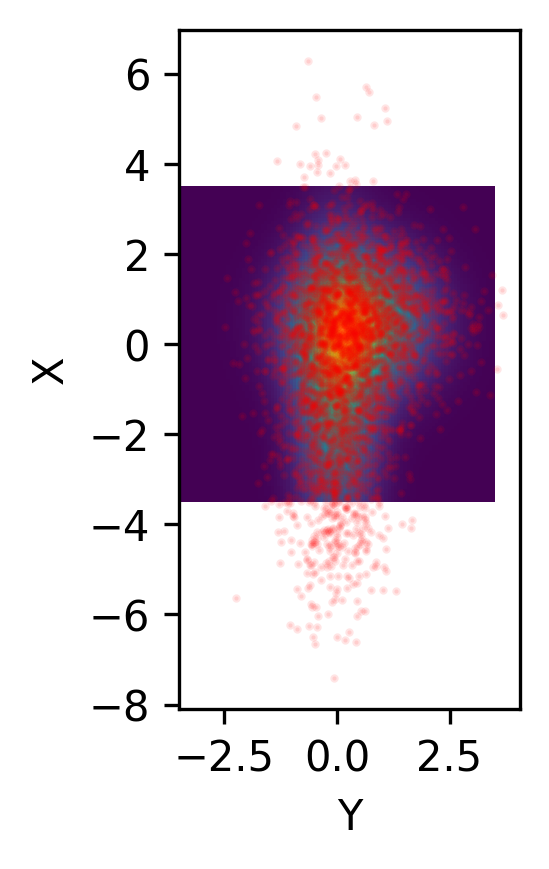

In [12]:
bump1 = Gaussian(mean=-1, stdev=2, scope=0) * Gaussian(mean=0, stdev=0.6, scope=1)
bump2 = Gaussian(mean=0.5, stdev=1, scope=0) * Gaussian(mean=0.5, stdev=1, scope=1)
spn = 0.5 * bump1 + 0.5 * bump2

info = spnhelp.get_pdf_grid_values(spn, (7, 7), np.array([0, 0]), 100)
spnhelp.show_data(info)


samples = spnhelp.sample_from_spn(spn, 4000)
plt.scatter(samples[:, 1], samples[:, 0], s=1, alpha=0.1, c = "red")

np.cov(samples, rowvar=False)

### Testing uniform density

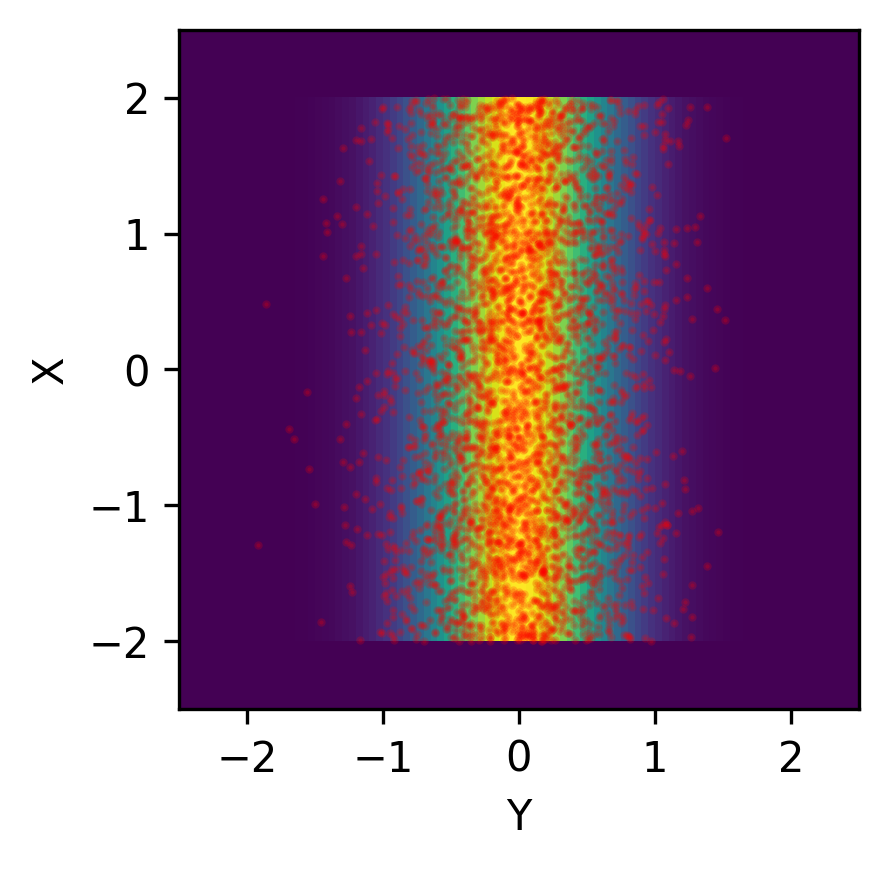

In [13]:
spn = Uniform(start=-2, end=2, scope=0) * Gaussian(mean=0, stdev=0.5, scope=1)
spn2 = Uniform(start=-2, end=2, scope=0) * Gaussian(mean=0, stdev=0.5, scope=1)
mix = 0.5 * spn + 0.5 * spn2
info = spnhelp.get_pdf_grid_values(mix, (5, 5), np.array([0, 0]), 100)
spnhelp.show_data(info)
samples = spnhelp.sample_from_spn(mix, 4000)
plt.scatter(samples[:, 1], samples[:, 0], s=1, alpha=0.2, c = "red");

# Approximating 1d gaussian with uniforms and slopyforms

21
23
21
21
21
20


''

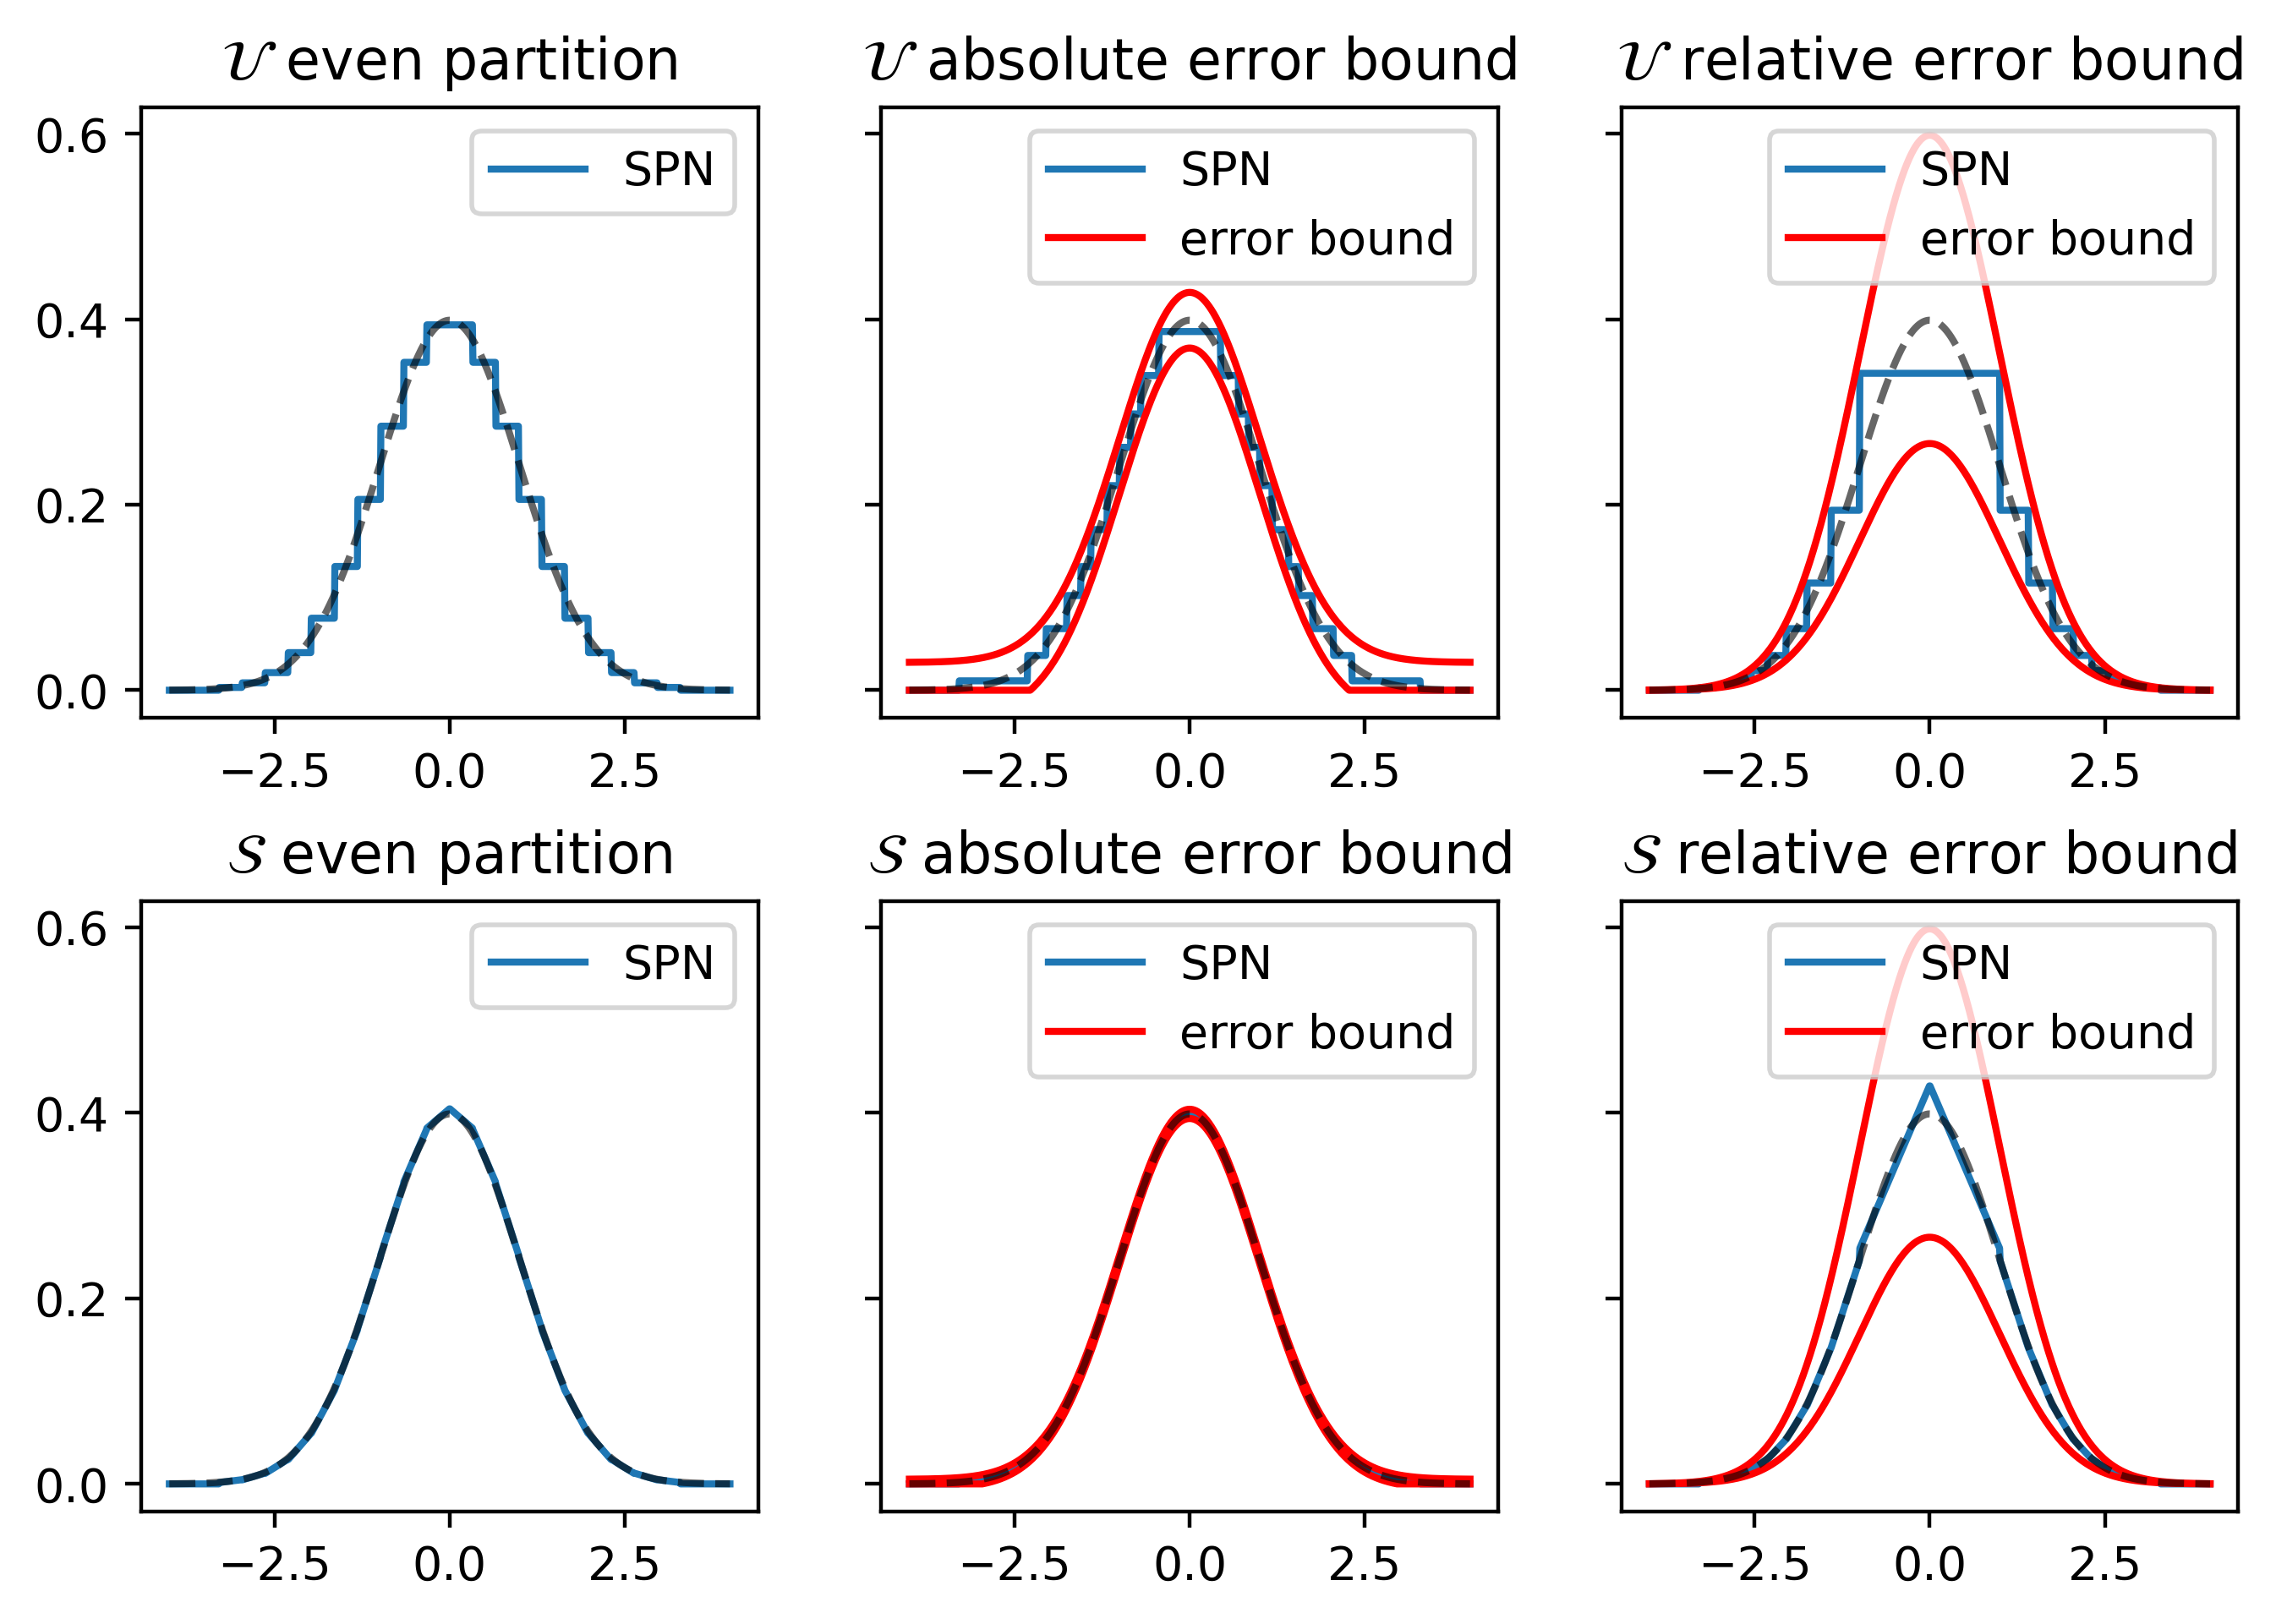

In [14]:
sd, mean = 1, 0
x = np.linspace(-4, 4, 1000)


fig, ax = plt.subplots(2,3, figsize=(8,5.5), sharey=True)
fig.subplots_adjust(hspace=0.3)


titles = ["$\mathcal{U}$ even partition", "$\mathcal{U}$ absolute error bound", "$\mathcal{U}$ relative error bound", "$\mathcal{S}$ even partition", "$\mathcal{S}$ absolute error bound", "$\mathcal{S}$ relative error bound"]
slopes = [False, False, False, True, True ,True]
criterions = [spnhelp.CRIT_even_partition, spnhelp.CRIT_uniform_bounded_deviation, spnhelp.CRIT_uniform_bounded_ratio, spnhelp.CRIT_even_partition, spnhelp.CRIT_slopyform_absolute_error, spnhelp.CRIT_slopyform_bounded_ratio]
crit_params = [20, 0.03, 1.5, 20, 0.005, 1.5]
ratio_bounds = [0.0, 0.0] + [crit_params[2]] + [0.0, 0.0] + [crit_params[5]]
deviation_bounds = [0.0] + [crit_params[1]] + [0.0, 0.0] + [crit_params[4]] + [0, 0]
for i, (slope, crit, crit_param, ratio_b, devia_b, title) in enumerate(zip(slopes, criterions, crit_params, ratio_bounds, deviation_bounds, titles)):
    coords = int(i // (len(slopes)*0.5)), int(i % (len(slopes)*0.5))
    spn = spnhelp.lgpgm_to_spn("A" @ (sd*lgpgm.noise + mean), crit_param=crit_param, crit=crit, disc_leaves=True, sloped=slope)
    print(get_number_of_nodes(spn))

    ax[coords].plot(x, likelihood(spn, x.reshape(-1, 1)), label = "SPN")
    if ratio_b != 0:
        ax[coords].plot(x, stats.norm.pdf(x, loc=mean, scale=sd)*ratio_b, c = "r", label = "error bound")
        ax[coords].plot(x, stats.norm.pdf(x, loc=mean, scale=sd)/ratio_b, c = "r")
    elif devia_b != 0:
        ax[coords].plot(x, np.maximum(0, stats.norm.pdf(x, loc=mean, scale=sd) + devia_b), c = "r", label = "error bound")
        ax[coords].plot(x, np.maximum(0, stats.norm.pdf(x, loc=mean, scale=sd) - devia_b), c = "r")
    # else:
    ax[coords].plot(x, stats.norm.pdf(x, loc=mean, scale=sd), linestyle="dashed", c = "k", alpha = 0.6)
    ax[coords].legend()
    ax[coords].set_title(title)
;

# Same, but 2d independent gaussians

43
47
43
43
43
41


(-0.5, 299.5, 199.5, -0.5)

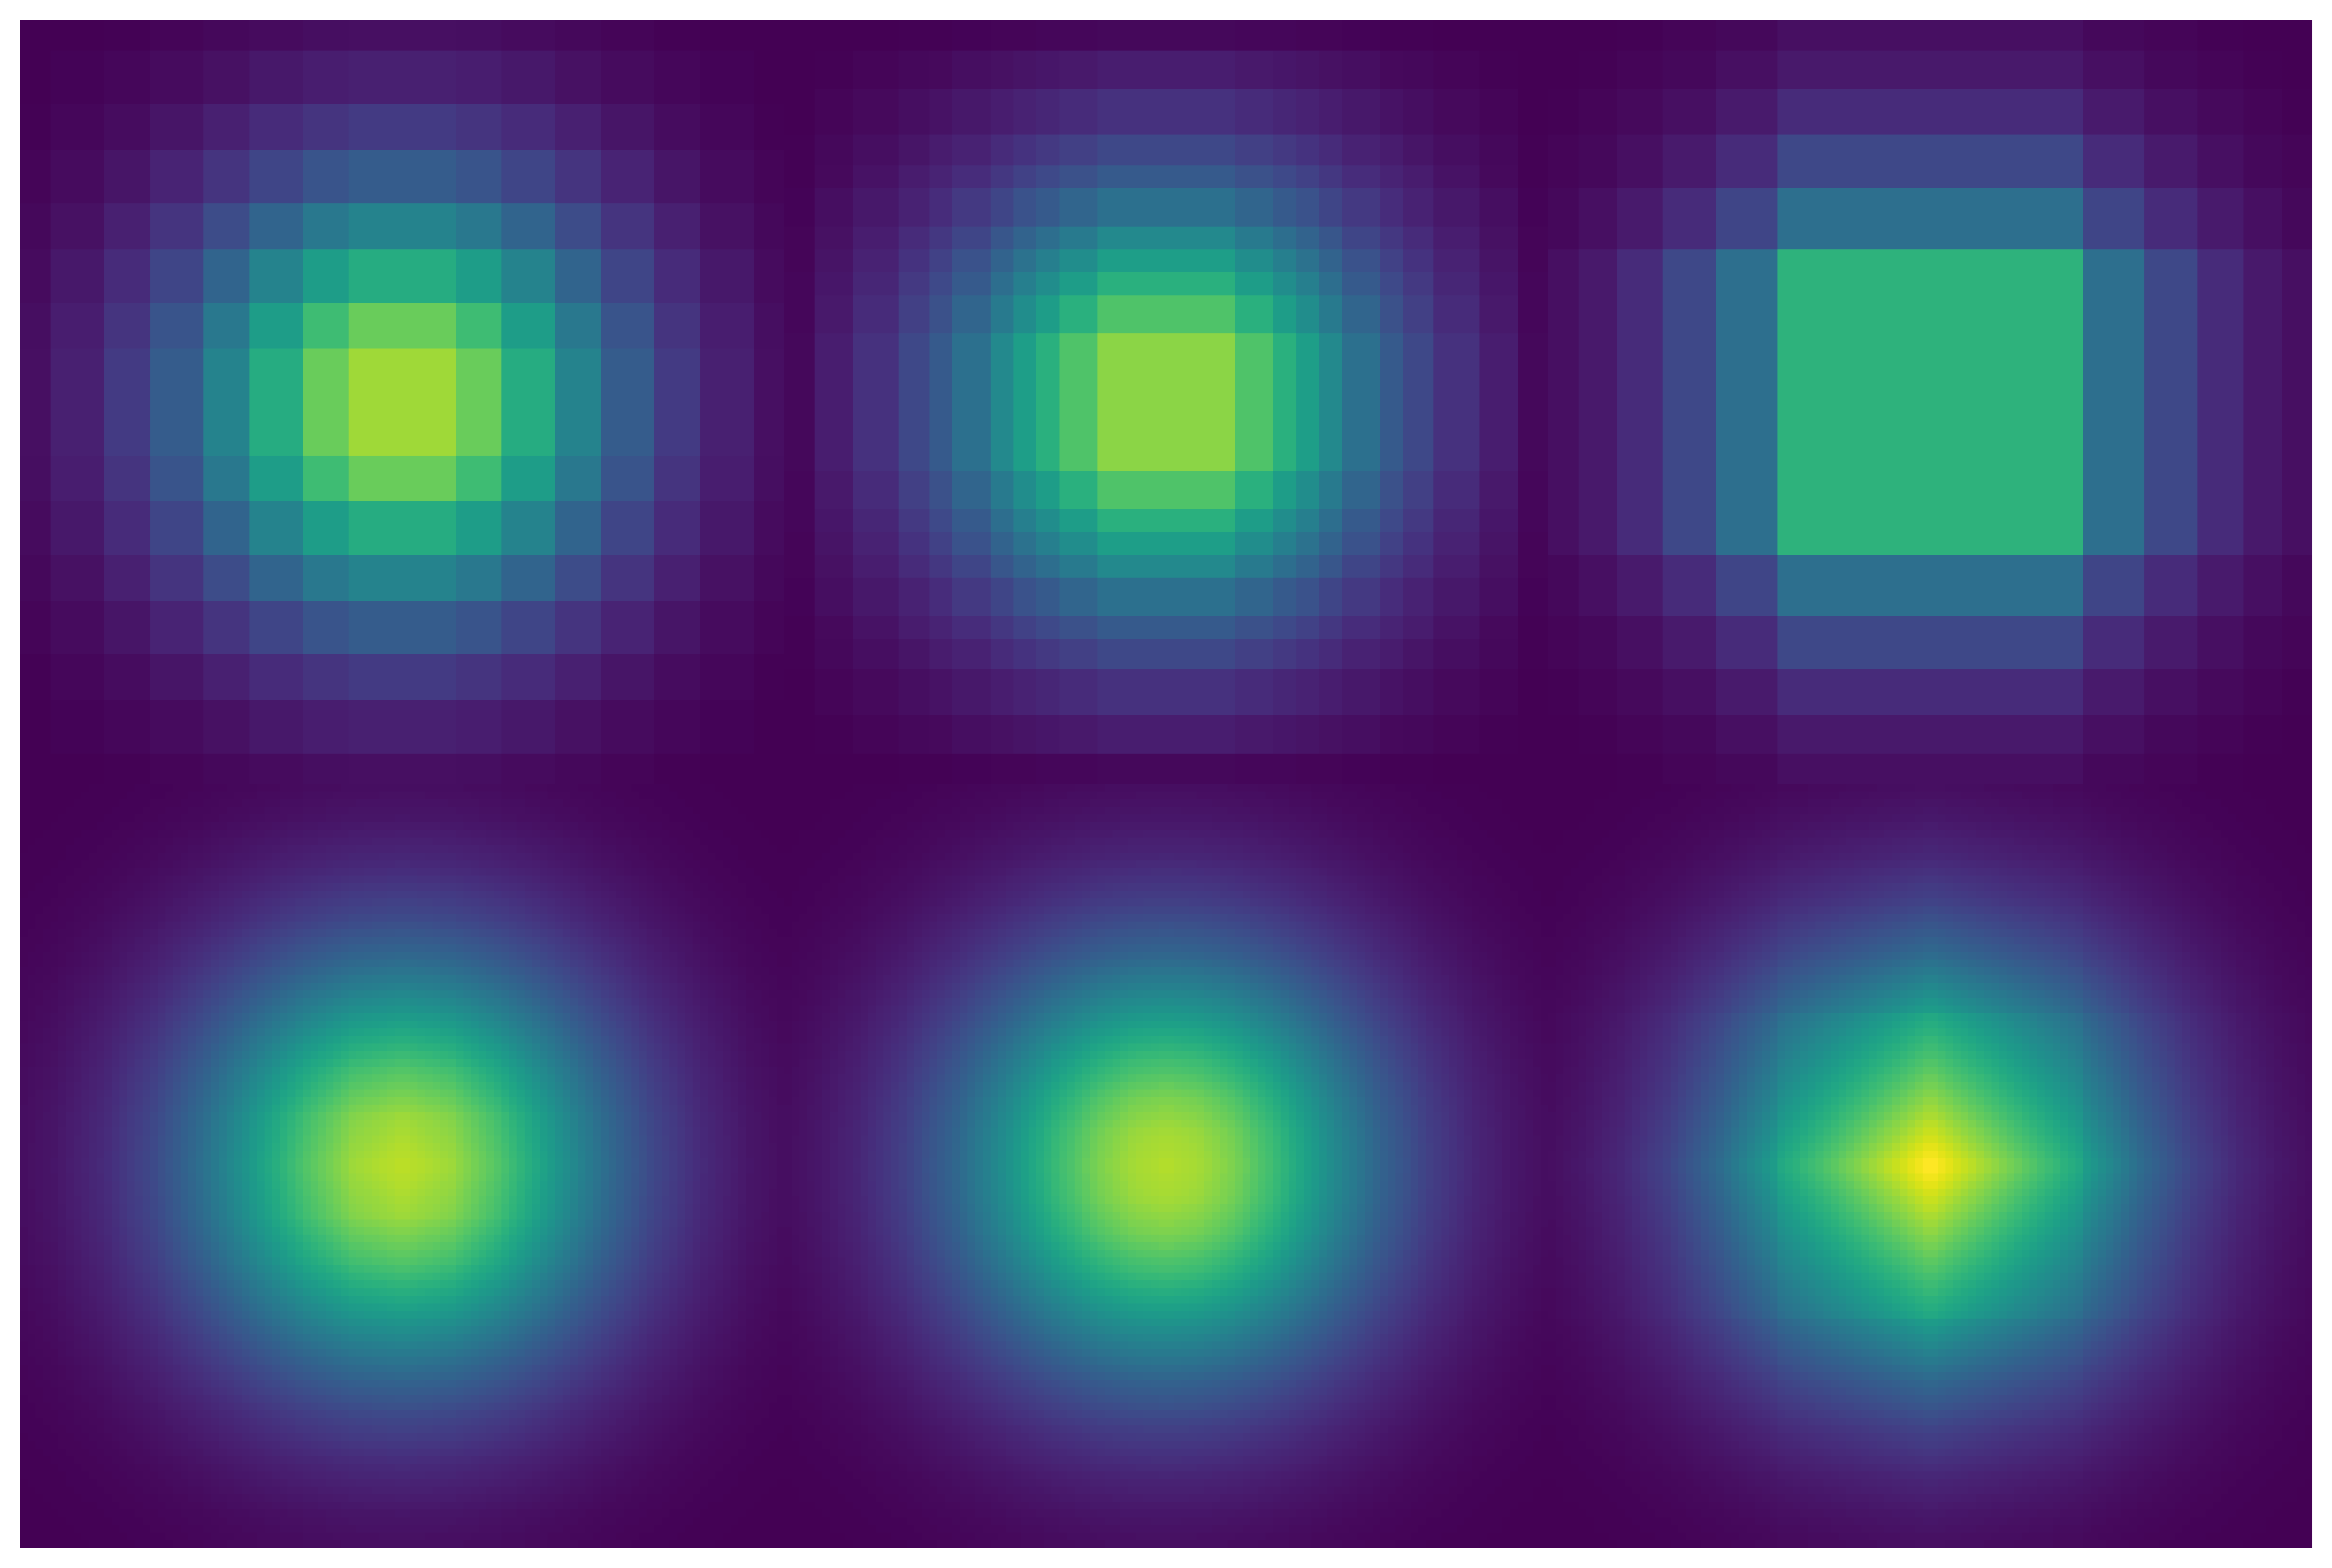

In [15]:
plt.rcParams["figure.figsize"] = (15, 10)



A = "A" @ lgpgm.noise
B = "B" @ lgpgm.noise
A & B


slopes = [False, False, False, True, True ,True]
criterions = [spnhelp.CRIT_even_partition, spnhelp.CRIT_uniform_bounded_deviation, spnhelp.CRIT_uniform_bounded_ratio, spnhelp.CRIT_even_partition, spnhelp.CRIT_slopyform_absolute_error, spnhelp.CRIT_slopyform_bounded_ratio]
crit_params = [20, 0.03, 1.5, 20, 0.005, 1.5]
ratio_bounds = [0.0, 0.0] + [crit_params[2]] + [0.0, 0.0] + [crit_params[5]]
deviation_bounds = [0.0] + [crit_params[1]] + [0.0, 0.0] + [crit_params[4]] + [0, 0]

heatmaps = []
for i, (slope, crit, crit_param,ratio_b, devia_b) in enumerate(zip(slopes, criterions, crit_params, ratio_bounds, deviation_bounds)):
    spn = spnhelp.lgpgm_to_spn(A, crit_param=crit_param, crit=crit, disc_leaves=True, sloped=slope)
    print(get_number_of_nodes(spn))
    vals, _, _ = spnhelp.get_pdf_grid_values(spn, (5, 5), np.array([0, 0]), 100)
    heatmaps.append([vals])
heatmaps = np.array(heatmaps)

upper = heatmaps[:3]
lower = heatmaps[3:]
upper_flat = np.reshape(upper, (-1, 100)).T
lower_flat = np.reshape(lower, (-1, 100)).T
stacked = np.vstack((upper_flat, lower_flat))
# heatmaps = np.reshape(heatmaps, (-1, 100)).T

plt.imshow(stacked);
plt.axis("off")

# Again same, but 2d dependent gaussians this time

     A     B
A  1.0  0.50
B  0.5  1.25


(-0.5, 599.5, 399.5, -0.5)

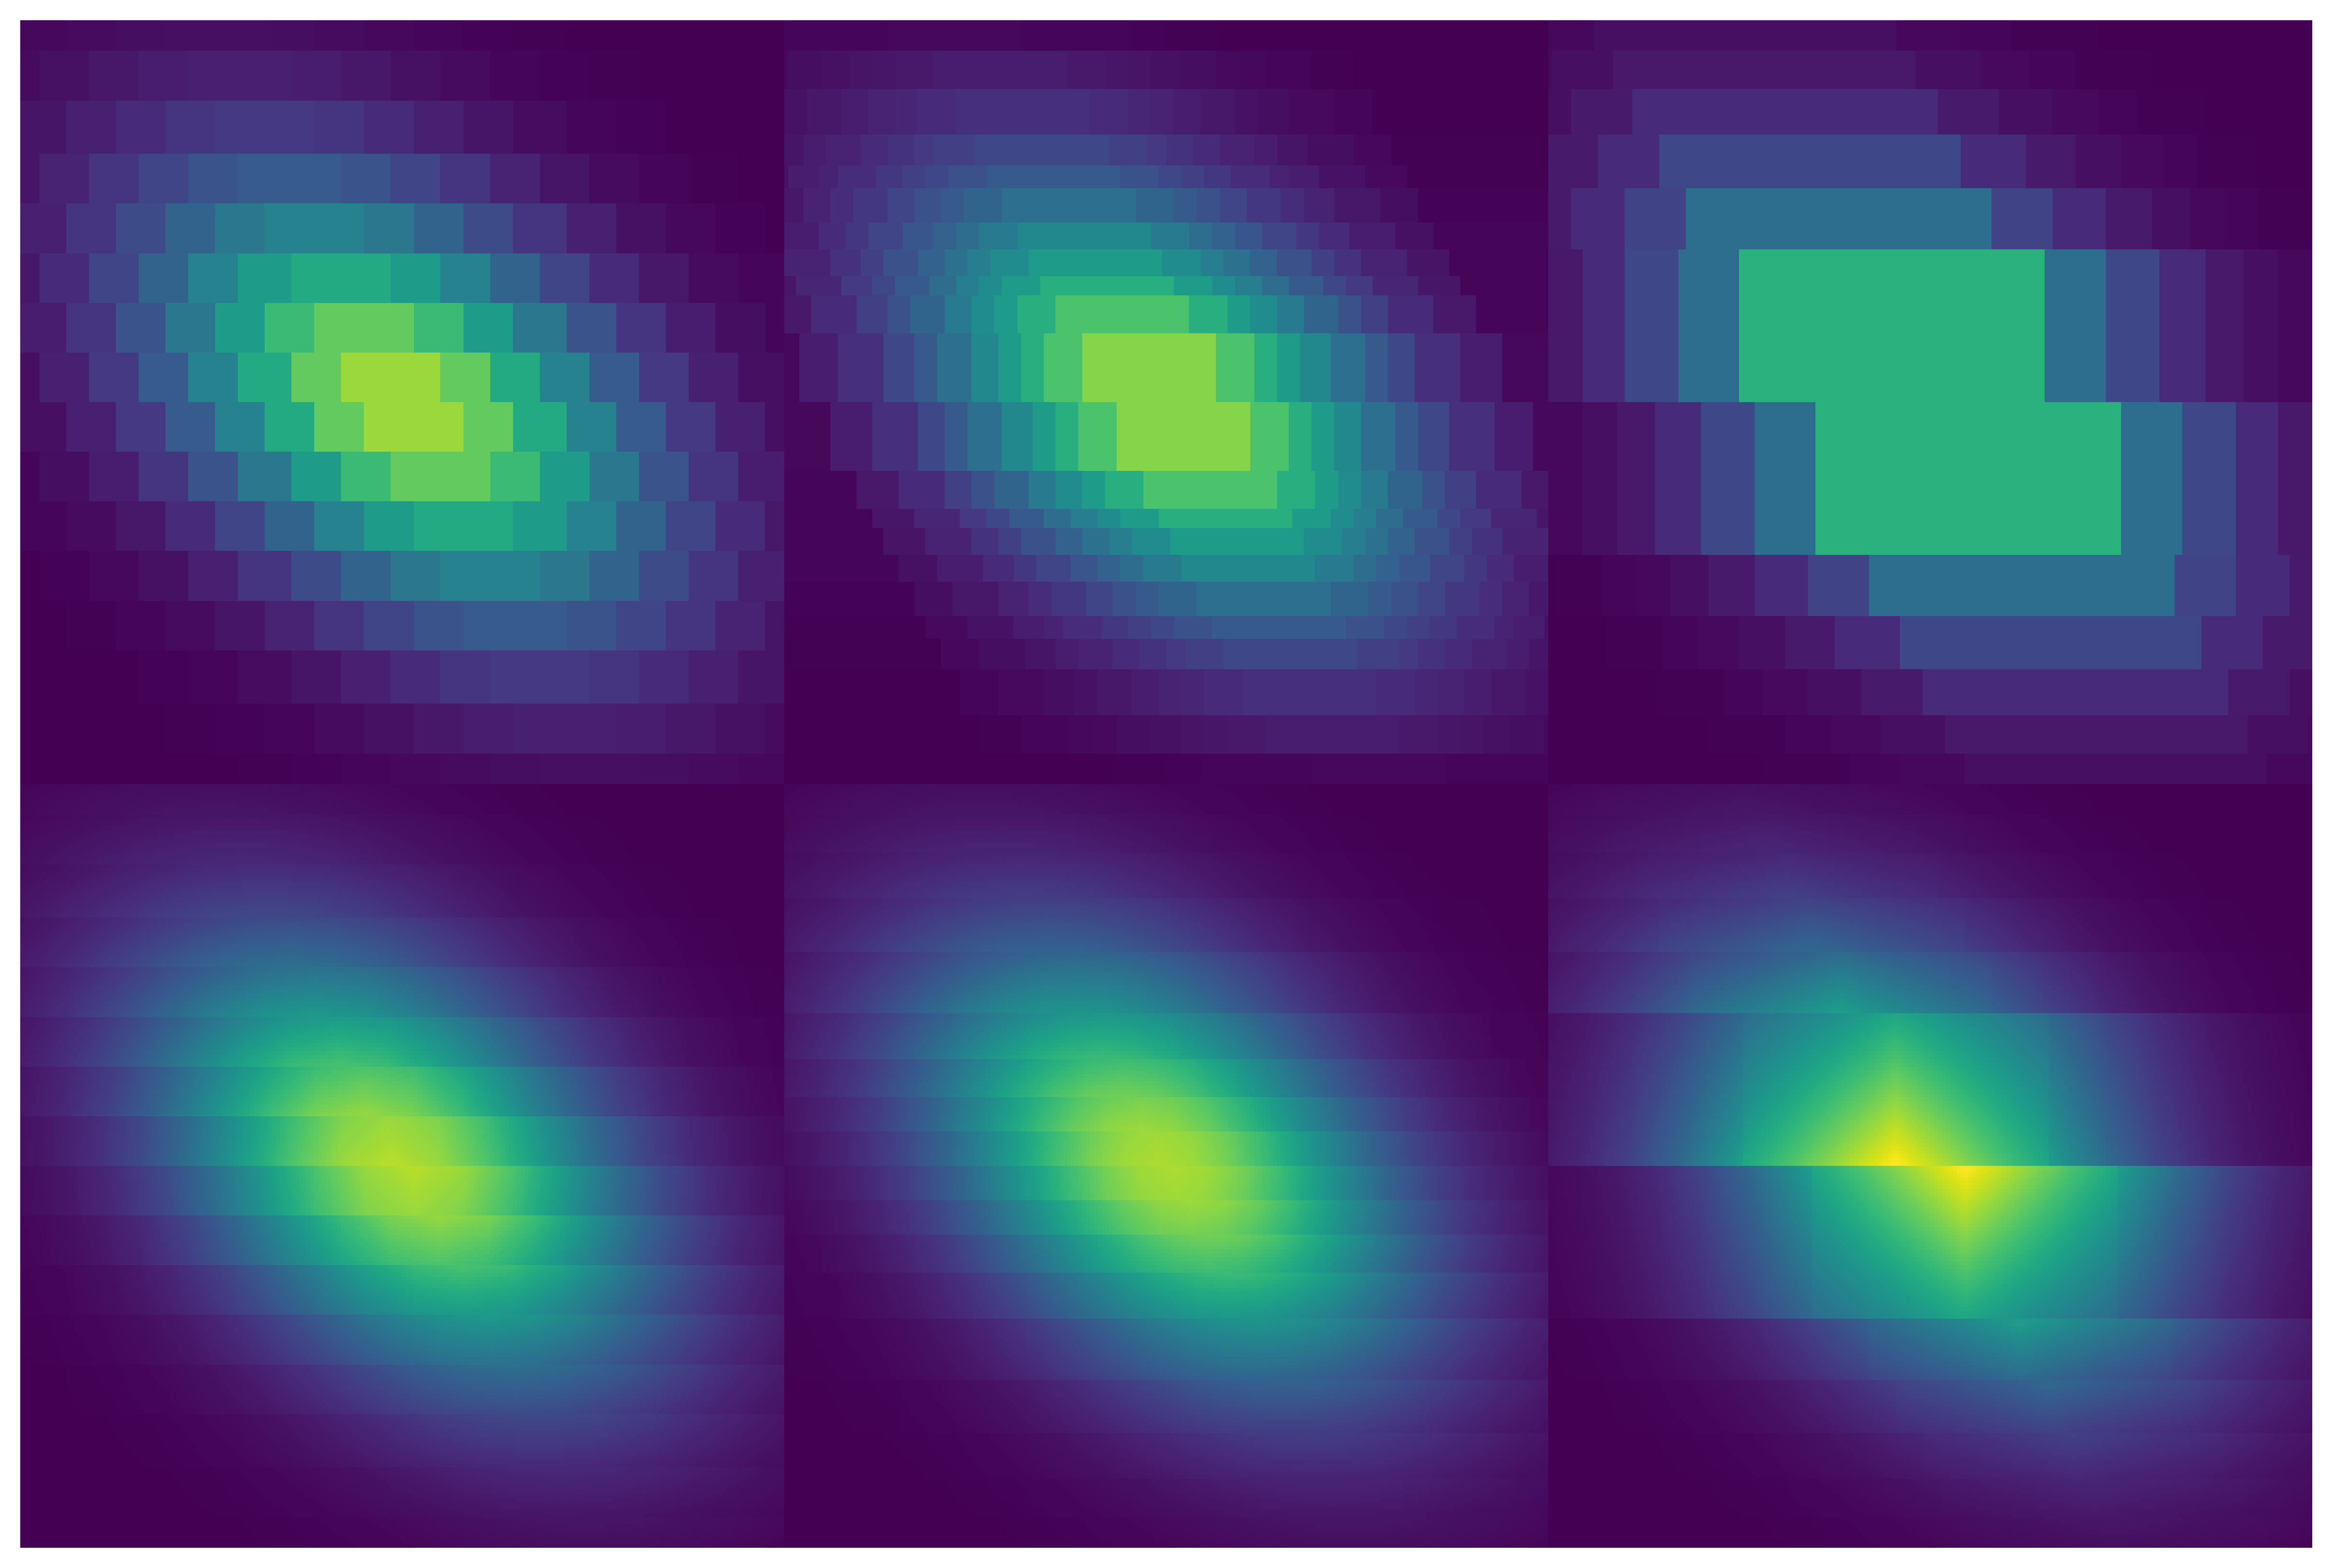

In [16]:
plt.rcParams["figure.figsize"] = (15, 10)


A = "A" @ lgpgm.noise
B = "B" @ (0.5*A + lgpgm.noise)

print(A.get_Σ())

n = 200

slopes = [False, False, False, True, True ,True]
criterions = [spnhelp.CRIT_even_partition, spnhelp.CRIT_uniform_bounded_deviation, spnhelp.CRIT_uniform_bounded_ratio, spnhelp.CRIT_even_partition, spnhelp.CRIT_slopyform_absolute_error, spnhelp.CRIT_slopyform_bounded_ratio]
crit_params = [20, 0.03, 1.5, 20, 0.005, 1.5]
ratio_bounds = [0.0, 0.0] + [crit_params[2]] + [0.0, 0.0] + [crit_params[5]]
deviation_bounds = [0.0] + [crit_params[1]] + [0.0, 0.0] + [crit_params[4]] + [0, 0]
heatmaps = []
for i, (slope, crit, crit_param,ratio_b, devia_b) in enumerate(zip(slopes, criterions, crit_params, ratio_bounds, deviation_bounds)):
    spn = spnhelp.lgpgm_to_spn(A, crit_param=crit_param, crit=crit, disc_leaves=True, sloped=slope)
    vals, _, _ = spnhelp.get_pdf_grid_values(spn, (5, 5), np.array([0, 0]), n)
    heatmaps.append([vals.T])
heatmaps = np.array(heatmaps)

upper = heatmaps[:3]
lower = heatmaps[3:]
upper_flat = np.reshape(upper, (-1, n)).T
lower_flat = np.reshape(lower, (-1, n)).T
stacked = np.vstack((upper_flat, lower_flat))
# heatmaps = np.reshape(heatmaps, (-1, 100)).T

plt.imshow(stacked);
plt.axis("off")